# Using Graph Neural Networks for Site-of-Metabolism Prediction and its Applications to Ranking Promiscuous Enzymatic Products

This notebook demonstrates usage of the GNN-SOM models for site-of-metabolism prediction.

In [1]:
import json
from os.path import isfile

import torch
from torch_geometric.data import Data
from rdkit.Chem import Draw
import requests

from IPython.display import SVG

from gnn_som import createGnnSom, loadGnnSomState
from gnn_som.MolFromKcf import MolFromKcfFile

/home/user/anaconda3/envs/som/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load configuration file. This file describes feature mappings as well as various model parameters needed to bring them up.

In [2]:
with open('data/config.json', 'r') as f:
    config = json.load(f)
config['features']['enzyme'] = [tuple(ec) for ec in config['features']['enzyme']] 

Configure several variants of the model, each was trained on a different data split and all will contribute to the final SOM prediction.

In [3]:
models = []
for i, params in enumerate(config['models']):
    model = createGnnSom(*config['models'][i])
    loadGnnSomState(model, torch.load('data/model%d.pt' % i, map_location=torch.device('cpu')))
    models.append(model)

Load the query molecule and select the enzyme. In this example, we evaluate interaction between compound [C00355](https://www.genome.jp/entry/C00355) and enzyme [1.10.3.1](https://www.genome.jp/entry/1.10.3.1), which corresponds to the right side of rpair RP00123.

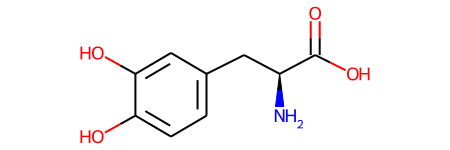

In [4]:
molecule = 'C00355'
enzyme = (1, 10)
if not isfile(molecule + '.kcf'):
    with open(molecule + '.kcf', 'wb') as f:
        f.write(requests.get('https://www.genome.jp/entry/-f+k+' + molecule).content)
mol = MolFromKcfFile(molecule + '.kcf')
mol

Construct a graph representation of the molecule, which includes atom feature vectors and bond connectivity.

In [5]:
numFeatures = sum(len(feature) for feature in config['features'].values())
x = torch.zeros((mol.GetNumAtoms(), numFeatures), dtype=torch.float32)
for atom in mol.GetAtoms():
    x[atom.GetIdx(), config['features']['enzyme'].index(enzyme)] = 1
    offset = len(config['features']['enzyme'])
    x[atom.GetIdx(), offset + config['features']['element'].index(atom.GetSymbol())] = 1
    offset += len(config['features']['element'])
    x[atom.GetIdx(), offset + config['features']['kcfType'].index(atom.GetProp('kcfType'))] = 1

edgeIndex = torch.zeros((2, mol.GetNumBonds() * 2), dtype=torch.int64)
for bond in mol.GetBonds():
    i = bond.GetIdx()
    edgeIndex[0][i * 2] = bond.GetBeginAtomIdx()
    edgeIndex[1][i * 2] = bond.GetEndAtomIdx()
    edgeIndex[0][i * 2 + 1] = bond.GetEndAtomIdx()
    edgeIndex[1][i * 2 + 1] = bond.GetBeginAtomIdx()

data = Data(x=x, edgeIndex=edgeIndex)
data

Data(x=[14, 157], edgeIndex=[2, 28])

Predict SOM labels using multiple models and retain the average value for each atom.

In [6]:
y = None
for model in models:
    newY = torch.sigmoid(model(data.x, data.edgeIndex))
    y = newY if y is None else torch.add(y, newY)
y = torch.div(y, len(models))
y.shape

torch.Size([14, 1])

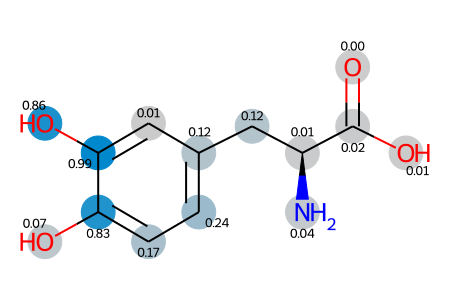

In [7]:
def hsvToRgb(h, s, v):
    c = v * s
    h /= 60.0
    x = c * (1 - abs(h % 2 - 1))
    if 0 <= h < 1:
        r, g, b = (c, x, 0)
    elif 1 <= h < 2:
        r, g, b = (x, c, 0)
    elif 2 <= h < 3:
        r, g, b = (0, c, x)
    elif 3 <= h < 4:
        r, g, b = (0, x, c)
    elif 4 <= h < 5:
        r, g, b = (x, 0, c)
    else:
        r, g, b = (c, 0, x)
    m = v - c
    return (r + m, g + m, b + m)
        
highlights = {}
highlightRadii = {}
minY = torch.min(y).item()
maxY = torch.max(y).item()
for atom in mol.GetAtoms():
    label = y[atom.GetIdx()].item()
    atom.SetProp('atomNote', '%.2f' % label)
    highlights[atom.GetIdx()] = [hsvToRgb(200, (label - minY) / (maxY - minY), 0.8)]
    highlightRadii[atom.GetIdx()] = 0.4

dwg = Draw.MolDraw2DSVG(450, 300)
opt = dwg.drawOptions()
opt.atomHighlightsAreCircles = True
dwg.DrawMoleculeWithHighlights(mol, '', highlights, {}, highlightRadii, {})
dwg.FinishDrawing()
SVG(dwg.GetDrawingText().replace('svg:', ''))
